# Half Harmonic Oscillator

In [2]:
from sympy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sympy.interactive import printing
printing.init_printing(use_latex=True)
from sympy.functions.special.polynomials import hermite

In [3]:
class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In this ipython notebook we calculate $\hat{x}$ and $\hat{p}$ operators for the half harmonic oscillator

In [4]:
def half_harmonic(n,x):
    A = lambda n: root(1/pi,4)/sqrt(2**(2*n)*factorial(2*n+1))
    #nonnegative = lambda x: 0 if x < 0 else 1
    psi = A(n)*hermite(2*n+1,x)*exp(-x**2/2)
    #psi = nonnegative(x)* A(n)*Herm(2*n+1,x)*np.exp(-x**2/2) 
    return psi

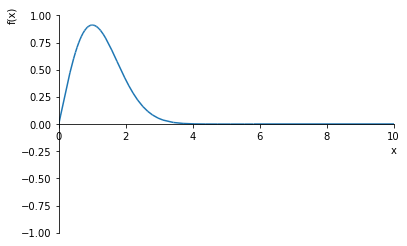

In [5]:
from ipywidgets import widgets

x = symbols('x')
def plotpsi(n):
    plot(half_harmonic(n,x),xlim=(0,10),ylim=(-1,1))
n_slider = widgets.IntSlider(min=0, max=10, step=1, value=0)
widgets.interactive(plotpsi,n=n_slider)

In [6]:
N(half_harmonic(100,100))

Elements of $\hat{x}$ are defined as follow:

In [7]:
def integrand(x,n,m):
    return half_harmonic(n,x)*x*half_harmonic(m,x)

def X_el(n,m):
    return N( integrate(integrand(x,n,m),(x,0,100)) )
#X_el = lambda n,m: N( integrate(integrand(x,n,m),(x,0,100)) )
X_el_vectorized = np.vectorize(X_el, otypes = [np.ndarray])
def x_el_map(params):
    n,m = params
    return X_el(n,m)

Now we calculate $10 \times 10$ matrix for $\hat{x}$

In [ ]:
%%timeii
SIZE = 100
import itertools    
from multiprocessing import Pool
parameters = list(itertools.product(range(SIZE),range(SIZE)))
if __name__ == '__main__':
    with Pool(4) as p:
        X = p.map(x_el_map,parameters)
    
X = np.reshape(X,[SIZE,SIZE])
X = X.astype(float)
np.save('X'+str(SIZE)+'.npy',X)

In [ ]:
plt.figure(figsize=(10,10))
norm = MidpointNormalize(midpoint=0)
plt.matshow(X,fignum=0,vmin=-1,vmax=4, norm=norm,cmap=plt.cm.PRGn)
cbar = plt.colorbar()
plt.xlabel('$n$',fontsize=20); plt.ylabel('$m$',fontsize=20)
plt.tick_params(labelsize=20)
cbar.ax.tick_params(labelsize=20)

In the following we calculate a $100 \times 100$ matrix for $\hat{x}$. It will take long time so we save it. It can be loaded without recalculation. 

In [27]:
X = np.fromfunction(X_el_vectorized, (100,100), dtype=int)
X = X.astype('float')
np.save('X100.npy',X)

KeyboardInterrupt: 

In [29]:
np.shape(X)

In [90]:
def integrand(x,n,m):
    return half_harmonic(n,x)*diff(half_harmonic(m,x))

P_el = lambda n,m: N( integrate(integrand(x,n,m),(x,0,100)) )
P_el_vectorized = np.vectorize(P_el, otypes = [np.ndarray])

In [93]:
P = np.fromfunction(P_el_vectorized, (10,10), dtype=int)

P = P.astype('float')

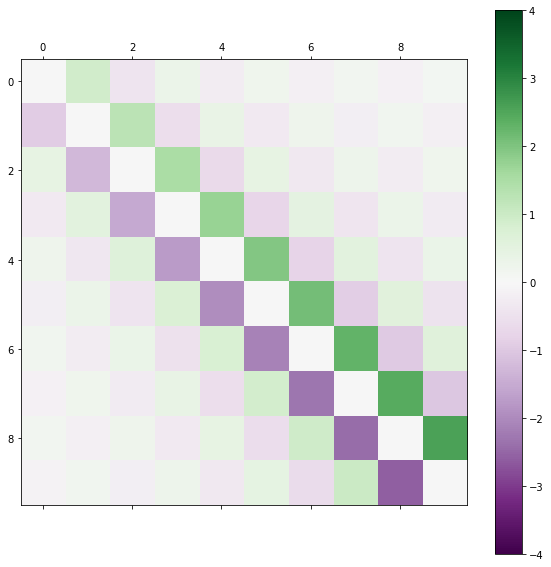

In [118]:
plt.figure(figsize=(10,10))
plt.matshow(P,fignum=0, vmin=-4, vmax= 4, norm=norm, cmap=plt.cm.PRGn)
plt.colorbar()

In [83]:
from qutip import *
x100 =np.load('./x100.npy')
X = x100[:cut,:cut]
X = Qobj(X)
X = tensor(identity(2),X)
OneX = Qobj(OneX)
OneX = tensor(identity(2),OneX)

In [147]:
a = tensor(identity(2),destroy(cut))
c = tensor(sigmam() ,identity(cut))
omega = 1.0

H = omega*a.dag()*a + 1*OneX*c.dag()

psi0 = tensor(basis(2,1),displace(cut,5)*basis(cut,0))
time = np.linspace(0.0,20,500)
opts = Options(ntraj=1,store_states=True)
Sol = mesolve(H, psi0, time, [],[X,a.dag()*a,c.dag()*c],options=opts,progress_bar=True)

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.10s. Est. time left: 00:00:00:00
40.0%. Run time:   0.13s. Est. time left: 00:00:00:00
50.0%. Run time:   0.16s. Est. time left: 00:00:00:00
60.0%. Run time:   0.20s. Est. time left: 00:00:00:00
70.0%. Run time:   0.23s. Est. time left: 00:00:00:00
80.0%. Run time:   0.26s. Est. time left: 00:00:00:00
90.0%. Run time:   0.29s. Est. time left: 00:00:00:00
Total run time:   0.32s


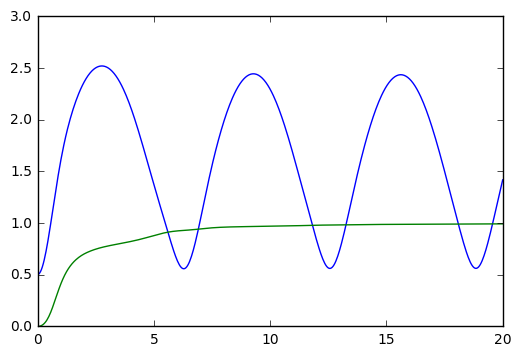

In [148]:
plt.plot(time,Sol.expect[0])
plt.plot(time,Sol.expect[2])

In [136]:
np.shape(cdc)

In [95]:
for m1 in range(cut):
    for m2 in range(m1+1):
        #print m1,m2
        psi_m1 = psi.subs(m,m1)
        psi_m2 = psi.subs(m,m2)
        ev=integrate(psi_m1*x*psi_m2,(x,0,oo))
        X[m1,m2] = ev
        X[m2,m1] = ev

In [102]:
print X[40,40]
print x100[40,40]

3.07989105512
8.12789362838


In [77]:
x = np.linspace(0,10,3000)
dx = x[1] - x[0]
psi_m1 = half_harmonic(20,x)
psi_m2 = half_harmonic(20,x)
ev=np.sum(psi_m1*x*psi_m2)*dx
ev

In [65]:
x100=np.load('x100.npy')

In [96]:
X - x100[:70,70]

array([[  1.12855654e+00,   4.60435290e-01,  -1.02749082e-01, ...,
         -3.02501510e-01,   7.08689008e-01,  -3.55701498e+00],
       [  4.60836236e-01,   1.69234517e+00,   6.31040502e-01, ...,
         -3.02934766e-01,   7.09111053e-01,  -3.55742627e+00],
       [ -1.02829084e-01,   6.30559555e-01,   2.11596831e+00, ...,
         -3.02414390e-01,   7.08604367e-01,  -3.55693271e+00],
       ..., 
       [  3.68895226e-04,  -4.65307533e-04,   5.36016306e-04, ...,
          1.85576704e+00,  -6.04257229e-01,  -3.86021586e+00],
       [ -9.24493046e-06,   1.18539673e-05,  -1.38839635e-05, ...,
         -1.61582589e+00,   2.83282258e+00,  -4.89710223e+00],
       [  3.59270859e-04,  -4.52958664e-04,   5.21542580e-04, ...,
         -6.05712014e-01,  -6.31029721e-01,  -1.42372053e+00]])

In [94]:
cut = 15
a = destroy(cut)

In [95]:
(a*a.dag())


Quantum object: dims = [[15], [15]], shape = [15, 15], type = oper, isherm = True
Qobj data =
[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   7.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   9.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  11.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.

In [96]:
xm=Qobj(X);
xm

Quantum object: dims = [[15], [15]], shape = [15, 15], type = oper, isherm = True
Qobj data =
[[  1.12837917e+00   4.60658866e-01  -1.03006454e-01   4.76827227e-02
   -2.80973138e-02   1.87528163e-02  -1.35128423e-02   1.02572218e-02
   -8.08516054e-03   6.55793116e-03  -5.43990268e-03   4.59483026e-03
   -3.93924636e-03   3.41957727e-03  -3.00009092e-03]
 [  4.60658866e-01   1.69256875e+00   6.30783131e-01  -1.36264730e-01
    6.19416738e-02  -3.60916531e-02   2.39052441e-02  -1.71306543e-02
    1.29491078e-02  -1.01736039e-02   8.23013829e-03  -6.81223054e-03
    5.74353782e-03  -4.91647664e-03   4.26224132e-03]
 [ -1.03006454e-01   6.30783131e-01   2.11571094e+00   7.61742999e-01
   -1.61590092e-01   7.26330507e-02  -4.19993756e-02   2.76649443e-02
   -1.97421036e-02   1.48742611e-02  -1.16553275e-02   9.40837712e-03
   -7.77335903e-03   6.54379522e-03  -5.59408382e-03]
 [  4.76827227e-02  -1.36264730e-01   7.61742999e-01   2.46832943e+00
    8.72686238e-01  -1.83056210e-01   8.1656

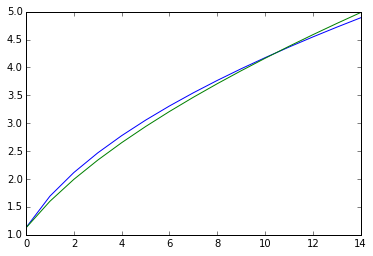

In [98]:
plt.plot(xm.diag())
n = np.arange(15)
plt.plot((n+1.22)**(0.59))

In [78]:
x.diag()[0]**(1/0.6)

In [52]:
cut = 50;
X = np.zeros([cut,cut]);

In [53]:
for m1 in range(cut):
    for m2 in range(m1+1):
        #print m1,m2
        psi_m1 = psi.subs(m,m1)
        psi_m2 = psi.subs(m,m2)
        ev=integrate(psi_m1*x*psi_m2,(x,0,oo))
        X[m1,m2] = N(ev)
        X[m2,m1] = N(ev)

<matplotlib.colorbar.Colorbar instance at 0x14e5c57a0>

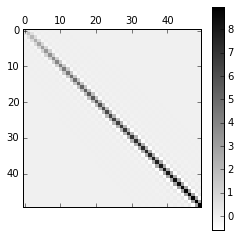

In [54]:
plt.matshow(X,cmap=plt.cm.gray_r)
plt.colorbar()

In [444]:
X50 = X

In [445]:
X50[0,49]

In [446]:
X50[0,48]

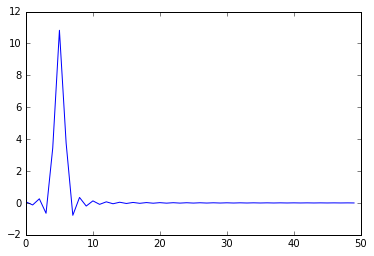

In [449]:
plt.plot(X[5,:])

In [55]:
np.save('x50',X)

In [16]:
cut = 10;
Check_one= np.zeros([cut,cut]);

In [17]:
for m in range(cut):
    for mp in range(m+1):
        n = 2*m+1
        n_p = 2*mp+1
        A = root(omega/pi,4)*sqrt(2)/sqrt(2**n*factorial(n))
        Ap = root(omega/pi,4)*sqrt(2)/sqrt(2**n_p*factorial(n_p))
        psi = A*hermite(n,sqrt(omega)*x)*exp(-omega*x**2/2)
        psip= Ap*hermite(n_p,sqrt(omega)*x)*exp(-omega*x**2/2)
        ev=integrate(psi*psip,(x,0,oo))
        Check_one[m,mp] = N(ev)
        Check_one[mp,m] = N(ev)

In [13]:
ev 

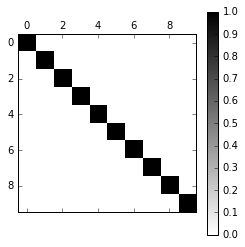

In [18]:
plt.matshow(Check_one,cmap=plt.cm.gray_r)
plt.colorbar()

In [14]:
x = symbols('x')
n = symbols('n')

SyntaxError: can't assign to function call (<ipython-input-14-53b95821123c>, line 3)

In [27]:
def f(n,x):
    return hermite(n,x)*exp(-x**2/2)
f(2,3)

In [33]:
f(64,0)

In [32]:
hermite(64,x)